In [2]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os
import joblib

# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [3]:
def read_merged(weather, year):
    return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year)).drop(columns=['Unnamed: 0'])

In [4]:
lightning = pd.concat([read_merged('lightning', year) for year in range(2015, 2023)])

In [5]:
features = ['LON', 'LAT', 'MONTH', 'TOTAL_COUNT']
X,y = lightning[features], lightning['POWER_OUTAGE']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=lightning['POWER_OUTAGE'])
X_tt, X_val, y_tt, y_val = train_test_split(X_train,y_train, test_size=0.2, stratify=y_train)

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier

## XGBoost classifier

In [7]:
xgb_model = Pipeline([('resampler',RandomUnderSampler()), ('clf',XGBClassifier(objective = 'binary:logistic'))])

In [8]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'clf__max_depth': range (5, 17,  2),
    'clf__n_estimators': range(100, 440, 40),
    'clf__learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(xgb_model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(X_tt, y_tt)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('resampler', RandomUnderSampler()),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'clf__learning_rate': [0.01, 0.1, 0.3],
                         'clf__max_depth': range(5, 17, 2),
                         'clf__n_estimators': range(100, 440, 40)},
             scoring='f1', verbose=True)

In [10]:
best_model = grid_search.best_estimator_

In [15]:
import joblib
joblib.dump(best_model,'../../models/xgb_lightning.pkl')

['../../models/xgb_lightning.pkl']

# SGD classifier

In [48]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
sgd = Pipeline([('resampler',RandomUnderSampler()), ('scaler', StandardScaler()), ('clf',SGDClassifier())])
sgd.fit(X_tt,y_tt)

Pipeline(steps=[('resampler', RandomUnderSampler()),
                ('scaler', StandardScaler()), ('clf', SGDClassifier())])

In [49]:
joblib.dump(sgd,'../../models/sgd_lightning.pkl')

['../../models/sgd_lightning.pkl']

# Examining performance

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score, PrecisionRecallDisplay

In [8]:
xgb_lightning = joblib.load('../../models/xgb_lightning.pkl')
sgd_lightning = joblib.load('../../models/sgd_lightning.pkl')

In [9]:
xgb_predictions = xgb_lightning.predict(X_val)
print('xGBoost results')
print('precision: ', precision_score(y_val,xgb_predictions))
print('recall: ', recall_score(y_val,xgb_predictions))
print('f1: ', f1_score(y_val,xgb_predictions))
print('accuracy score: ', accuracy_score(y_val,xgb_predictions))
print('balanced accuracy score: ', balanced_accuracy_score(y_val,xgb_predictions))

xGBoost results
precision:  0.06079837706014805
recall:  0.9531940810249933
f1:  0.11430588598084578
accuracy score:  0.8075175536367655
balanced accuracy score:  0.8793941595888475


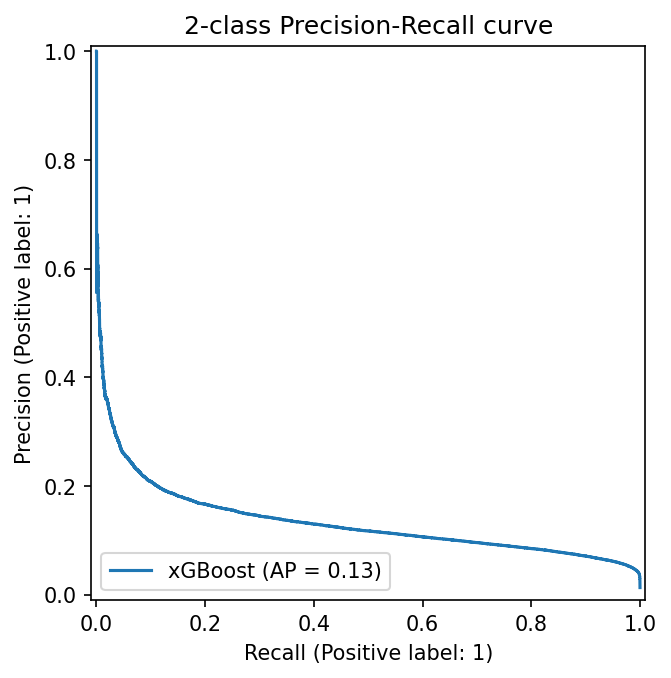

In [10]:
display = PrecisionRecallDisplay.from_estimator(
    xgb_lightning, X_val, y_val, name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [11]:
sgd_predictions = sgd_lightning.predict(X_val)
print('SGD results')
print('precision: ', precision_score(y_val,sgd_predictions))
print('recall: ', recall_score(y_val,sgd_predictions))
print('f1: ', f1_score(y_val,sgd_predictions))
print('accuracy: ', accuracy_score(y_val,sgd_predictions))
print('balanced accuracy: ', balanced_accuracy_score(y_val,sgd_predictions))

SGD results
precision:  0.017827521214476345
recall:  0.7047279617432103
f1:  0.034775330018905926
accuracy:  0.49023116011550366
balanced accuracy:  0.5960635983606128


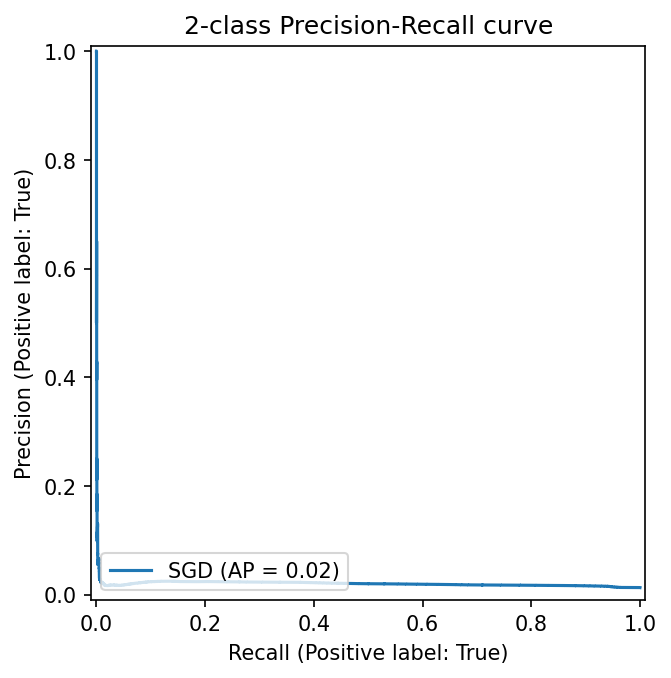

In [12]:
display = PrecisionRecallDisplay.from_estimator(
    sgd_lightning, X_val, y_val, name="SGD")
_ = display.ax_.set_title("2-class Precision-Recall curve")